## Webscraping top 100 from Billboard.com

In [1]:
# import libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import random

# find url and store it in a variable
url = "https://www.billboard.com/charts/hot-100/"

# download html with a get request
response = requests.get(url)
response.status_code # 200 status code means OK!

# parse html (create the 'soup')
soup = BeautifulSoup(response.content, "html.parser")


In [2]:
#initialize empty lists
title = []
artist = []
index = []

# iterate through the result set and retrive all the data, strip newline characters
for i in range(3,103):
    title.append(soup.select("#title-of-a-story")[i].get_text().strip())
for i in range(2,102):
    artist.append(soup.select(".a-font-primary-s")[i].get_text().strip())
for i in range(0,100):
    index.append(i+1)   

In [3]:
#lower-case all artists & titles
for i in range(0,100):
    artist[i] = artist[i].lower()
    title[i] = title[i].lower()

In [4]:
# each list becomes a column
top100 = pd.DataFrame({"chart_position":index,
                       "artist":artist,
                       "title":title
                      })

In [5]:
top100

chart_position                                    artist  \
0                1                              taylor swift   
1                2                                     adele   
2                3             the kid laroi & justin bieber   
3                4                   lil nas x & jack harlow   
4                5  silk sonic (bruno mars & anderson .paak)   
..             ...                                       ...   
95              96          swedish house mafia & the weeknd   
96              97                              cody johnson   
97              98                                  doja cat   
98              99                                the weeknd   
99             100                                    giveon   

                              title  
0   all too well (taylor's version)  
1                        easy on me  
2                              stay  
3                     industry baby  
4             smokin out the window  
..                              ...  
95                  moth to a flame  
96                   'til you can't  
97                            woman  
98                   take my breath  
99                      for tonight  

[100 rows x 3 columns]

In [6]:
#write to csv

with open('top100.csv', 'w') as f:
        top100.to_csv(f, header= True, index=False)

## Get songs for clustering from Spotify-API

In [7]:
import config
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials
import requests
import pandas as pd
import math

#Initialize SpotiPy with user credentias
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))

#song = sp.search(q="woman", limit=1) 
#song["tracks"]["items"][0]["uri"]
#sp.audio_features(song["tracks"]["items"][0]["uri"])[0]

In [8]:
uri = 'spotify:user:9mtj6p9tgugxw8r33lmd5ef1k:playlist:5zmZ6CrKifQOtx6wJGhOG9'

username = uri.split(":")[2]
playlist_id = uri.split(":")[4]
results = sp.user_playlist_tracks(username, playlist_id)

# get spotify tracks from playlist 
def get_tracks(results):
    tracks = []
    for item in results['items']:
        tracks.append(item['track'])
    return(tracks)


#fill dataframe with 
def get_tracks_info(tracks):
    columns = ['song', 'song uri', 'artist', 'artist uri', 'artist genres', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
    df = pd.DataFrame(columns=columns)
    i = 0
    for track in tracks:
        features = sp.audio_features(track['uri'])
        df.loc[i, 'song'] = track['name']
        df.loc[i, 'song uri'] = track['uri']
        df.loc[i, 'artist'] = track['artists'][0]['name']
        df.loc[i, 'artist uri'] = track['artists'][0]['uri']
        df.loc[i, 'artist genres'] = sp.artist(track['artists'][0]['uri'])['genres']
        df.loc[i, 'danceability'] = features[0]['danceability']
        df.loc[i, 'energy'] = features[0]['energy']
        df.loc[i, 'key'] = features[0]['key']
        df.loc[i, 'loudness'] = features[0]['loudness']
        df.loc[i, 'mode'] = features[0]['mode']
        df.loc[i, 'speechiness'] = features[0]['speechiness']
        df.loc[i, 'acousticness'] = features[0]['acousticness']
        df.loc[i, 'instrumentalness'] = features[0]['instrumentalness']
        df.loc[i, 'liveness'] = features[0]['liveness']
        df.loc[i, 'valence'] = features[0]['valence']
        df.loc[i, 'tempo'] = features[0]['tempo']
        df.loc[i, 'duration_ms'] = features[0]['duration_ms']
        df.loc[i, 'time_signature'] = features[0]['time_signature']
        i += 1
    return(df)

tracks = get_tracks(results)

df = get_tracks_info(tracks) 

In [9]:
#write to csv

with open('tracks.csv', 'w') as f:
        df.to_csv(f, header= True, index=False)

### K-Means Clustering

In [10]:
import numpy as np
import pandas as pd
import pickle
from sklearn import datasets # sklearn comes with some toy datasets to practise
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.metrics import silhouette_score

In [11]:
#load the (bigger) dataset

data = pd.read_csv('song_data.csv')

In [12]:
#drop all columns containing strings, and first column(index)
X = data.select_dtypes(exclude=['object']).drop(['Unnamed: 0'], axis=1)

In [13]:
X.describe()

danceability         energy            key       loudness  \
count  222313.000000  222313.000000  222313.000000  222313.000000   
mean        0.572925       0.624311       5.277190      -8.831180   
std         0.179407       0.244550       3.605864       5.031409   
min         0.000000       0.000000       0.000000     -60.000000   
25%         0.454000       0.463000       2.000000     -10.614000   
50%         0.588000       0.663000       5.000000      -7.623000   
75%         0.708000       0.824000       9.000000      -5.565000   
max         0.995000       1.000000      11.000000       2.781000   

                mode    speechiness   acousticness  instrumentalness  \
count  222313.000000  222313.000000  222313.000000     222313.000000   
mean        0.621183       0.098195       0.279866          0.200119   
std         0.485094       0.124871       0.323469          0.333565   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.000000       0.036700       0.014000          0.000000   
50%         1.000000       0.050600       0.121000          0.000630   
75%         1.000000       0.094900       0.497000          0.283000   
max         1.000000       0.965000       0.996000          1.000000   

            liveness        valence          tempo   duration_ms  \
count  222313.000000  222313.000000  222313.000000  2.223130e+05   
mean        0.219634       0.448919     121.531551  2.349372e+05   
std         0.205911       0.252089      29.527075  1.347118e+05   
min         0.000000       0.000000       0.000000  1.312000e+03   
25%         0.097300       0.239000      99.857000  1.794130e+05   
50%         0.129000       0.434000     121.990000  2.180530e+05   
75%         0.274000       0.645000     139.400000  2.685000e+05   
max         1.000000       1.000000     248.019000  5.823661e+06   

       time_signature  
count   222313.000000  
mean         3.912205  
std          0.443912  
min          0.000000  
25%          4.000000  
50%          4.000000  
75%          4.000000  
max          5.000000

## Scaling features

In [14]:
scaler = StandardScaler()
scaler.fit(X) # fit the standard scaler (computes the mean and std to be used for later scaling)
print(scaler.mean_)

[ 5.72924979e-01  6.24310694e-01  5.27719027e+00 -8.83117955e+00
  6.21182747e-01  9.81950367e-02  2.79866393e-01  2.00119117e-01
  2.19634325e-01  4.48919406e-01  1.21531551e+02  2.34937217e+05
  3.91220486e+00]


In [15]:
X.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature'],
      dtype='object')

In [16]:
X_scaled = scaler.transform(X) #Perform standardization by centering and scaling, output: numpy array
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns) #build dataframe with scaled data and column titles of X

In [17]:
X_scaled_df.describe()

danceability        energy           key      loudness          mode  \
count  2.223130e+05  2.223130e+05  2.223130e+05  2.223130e+05  2.223130e+05   
mean   1.195401e-15  9.106792e-17  6.477775e-15  6.967178e-16 -3.303906e-17   
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   
min   -3.193450e+00 -2.552905e+00 -1.463506e+00 -1.016990e+01 -1.280545e+00   
25%   -6.628808e-01 -6.596248e-01 -9.088522e-01 -3.543390e-01 -1.280545e+00   
50%    8.402728e-02  1.582067e-01 -7.687225e-02  2.401280e-01  7.809175e-01   
75%    7.529002e-01  8.165610e-01  1.032434e+00  6.491595e-01  7.809175e-01   
max    2.352621e+00  1.536253e+00  1.587088e+00  2.307943e+00  7.809175e-01   

        speechiness  acousticness  instrumentalness      liveness  \
count  2.223130e+05  2.223130e+05      2.223130e+05  2.223130e+05   
mean  -1.493354e-16  5.466807e-16     -1.220660e-14 -9.841684e-16   
std    1.000002e+00  1.000002e+00      1.000002e+00  1.000002e+00   
min   -7.863767e-01 -8.652054e-01     -5.999418e-01 -1.066650e+00   
25%   -4.924716e-01 -8.219245e-01     -5.999418e-01 -5.941142e-01   
50%   -3.811560e-01 -4.911346e-01     -5.980531e-01 -4.401638e-01   
75%   -2.638769e-02  6.712674e-01      2.484706e-01  2.640258e-01   
max    6.941647e+00  2.213923e+00      2.397982e+00  3.789831e+00   

            valence         tempo   duration_ms  time_signature  
count  2.223130e+05  2.223130e+05  2.223130e+05    2.223130e+05  
mean   1.178246e-16  7.702864e-16  1.280342e-16    1.693736e-14  
std    1.000002e+00  1.000002e+00  1.000002e+00    1.000002e+00  
min   -1.780804e+00 -4.115945e+00 -1.734264e+00   -8.813030e+00  
25%   -8.327224e-01 -7.340585e-01 -4.121714e-01    1.977762e-01  
50%   -5.918330e-02  1.552643e-02 -1.253361e-01    1.977762e-01  
75%    7.778257e-01  6.051561e-01  2.491457e-01    1.977762e-01  
max    2.186064e+00  4.283788e+00  4.148662e+01    2.450478e+00

---- Save the freshly trained standard scaler with pickle

In [18]:
kmeans = KMeans(random_state=1234) # kmeans is the defined model

In [19]:
kmeans.fit(X_scaled_df) #Compute k-means clustering

KMeans(random_state=1234)

---- Do some research on the optimal K-value for the K-means

In [20]:
len(kmeans.labels_) # number of labels / datapoints in total

222313

In [21]:
# assign a cluster to each example
labels = kmeans.predict(X_scaled_df)
# retrieve unique clusters
clusters = np.unique(labels)


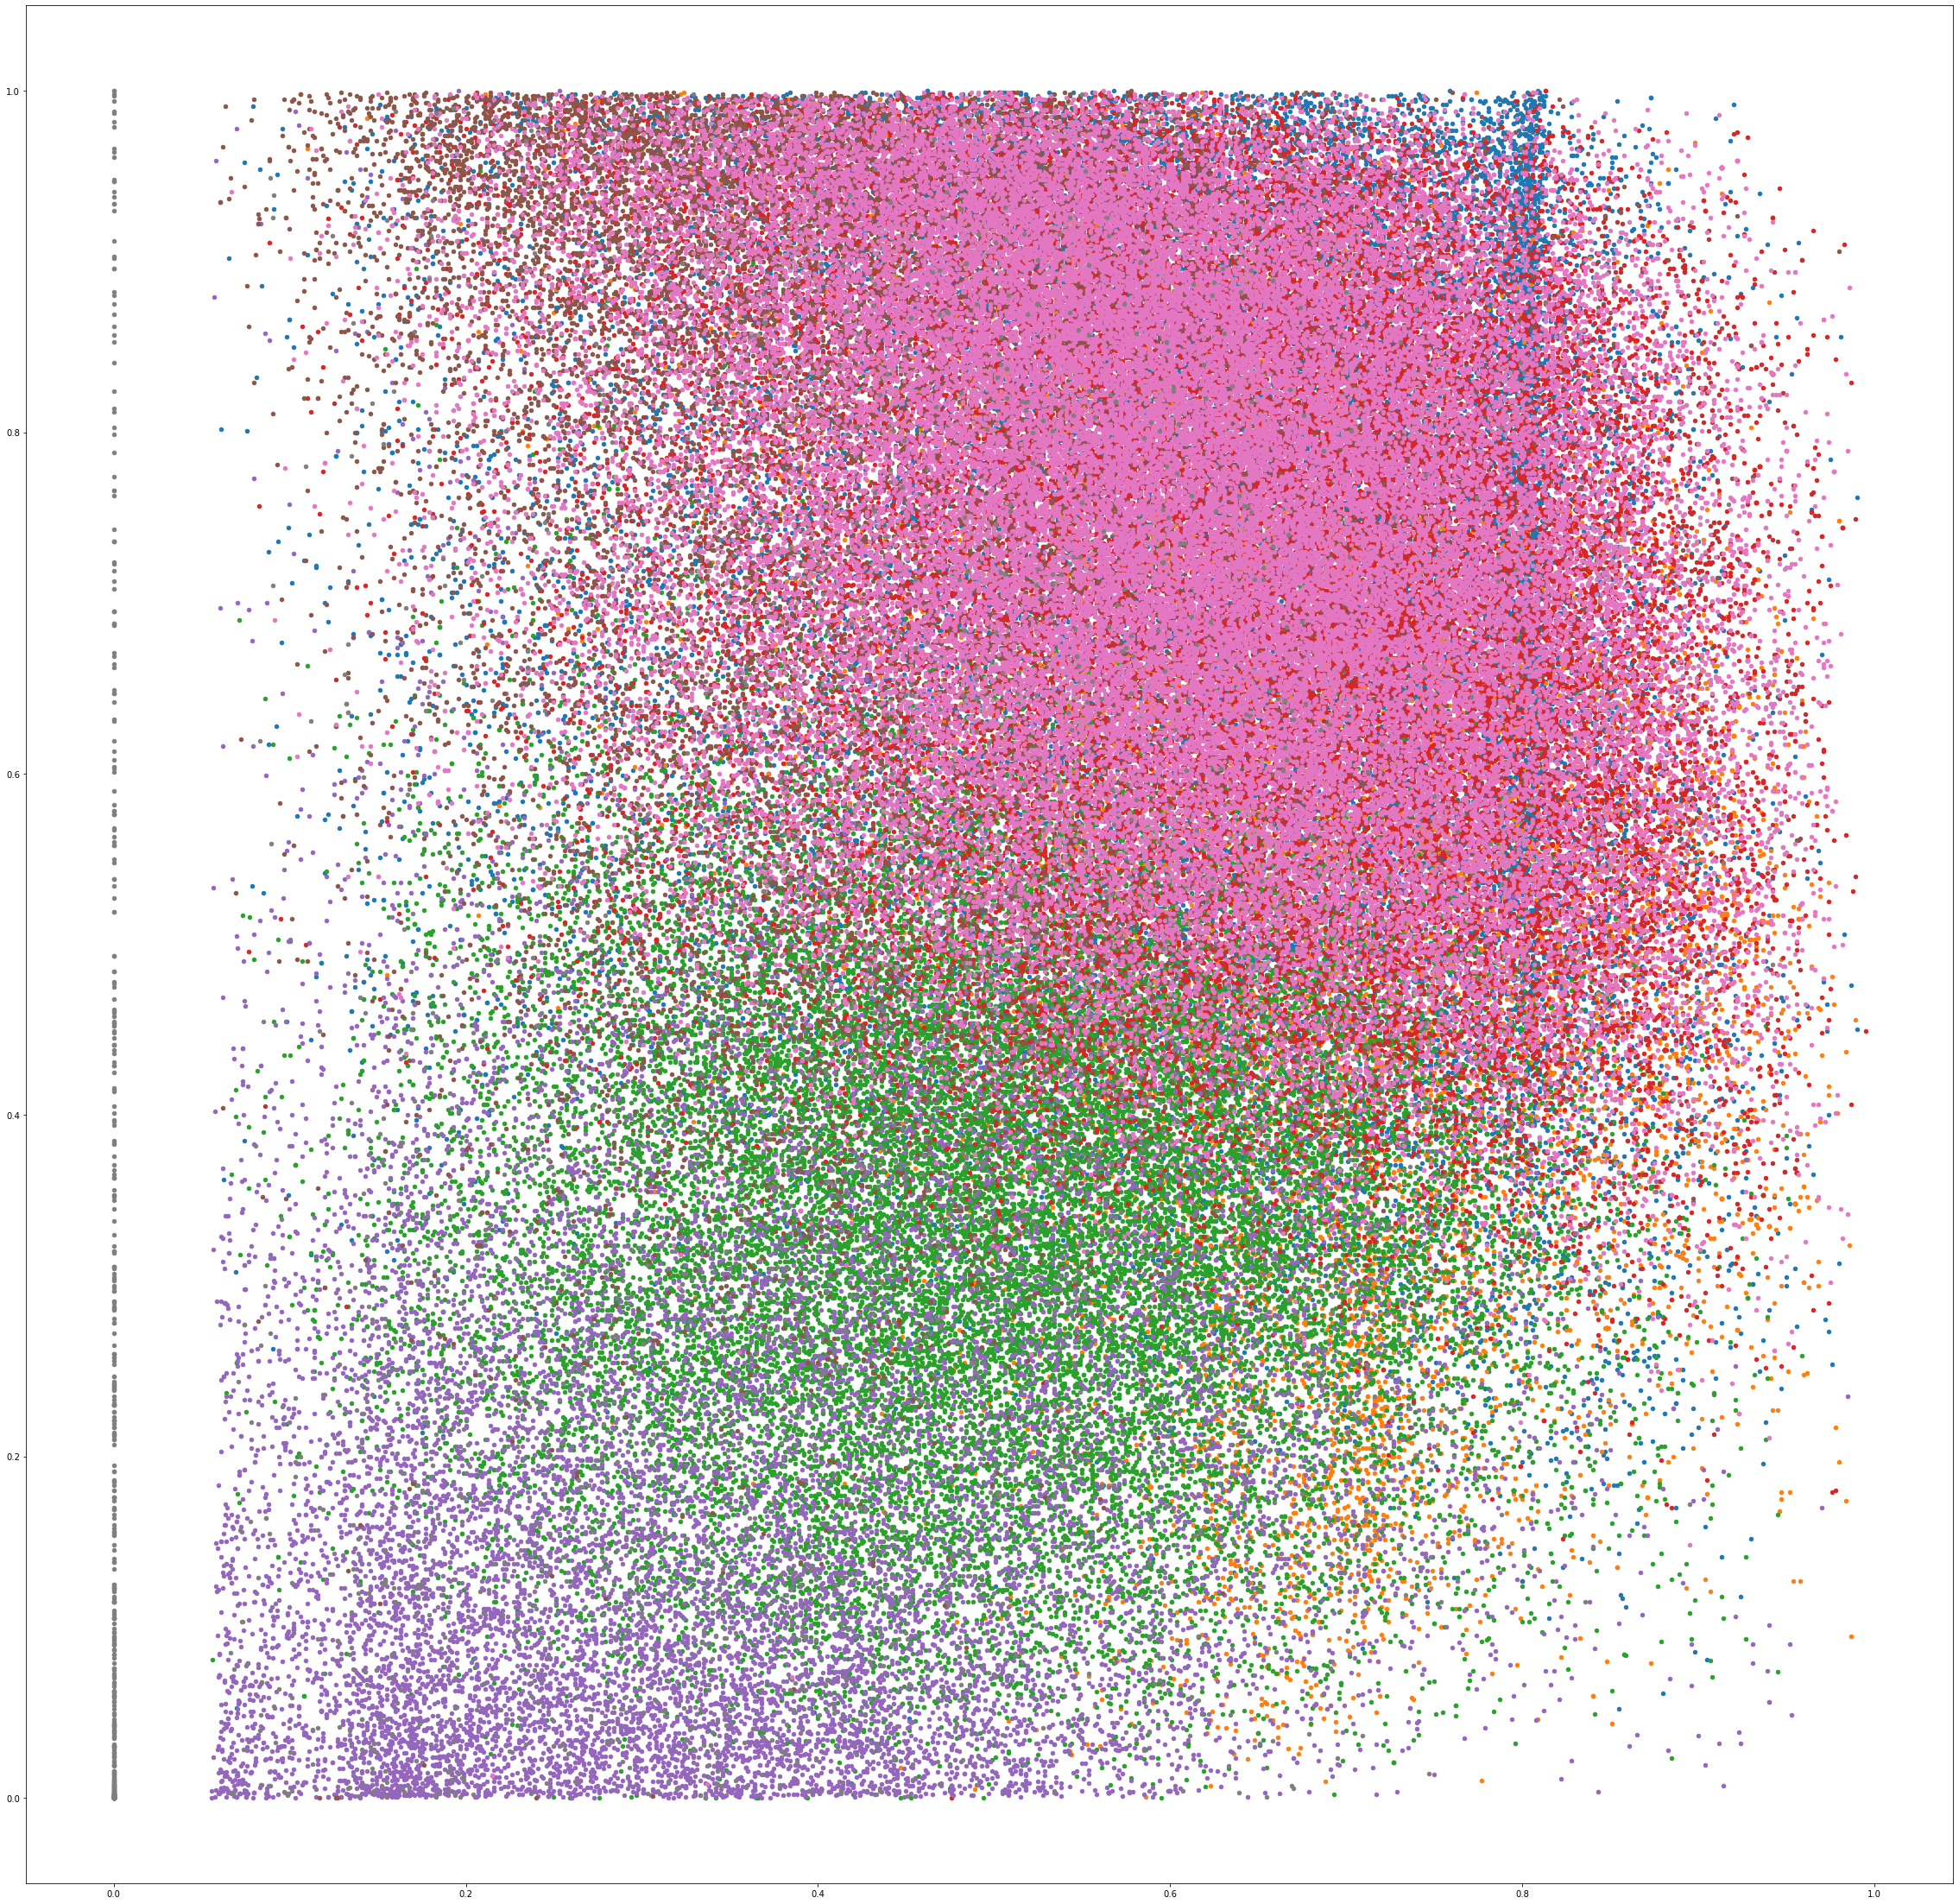

In [22]:
# create scatter plot for samples from each cluster
pyplot.figure(figsize=(40, 40))

for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    pyplot.scatter(X.to_numpy()[row_ix, 0], X.to_numpy()[row_ix, 1],s=20)
    # show the plot
    


pyplot.show()

Now we have our "model", let's get the clusters and how many observations has each cluster.

---- Save the final K-means model with pickle

Add cluster-column to original dataframe

In [23]:
clusters = kmeans.predict(X_scaled_df)# predicts clusters of all songs in the database and saves them in array
#clusters
#pd.Series(clusters).value_counts().sort_index()

In [24]:
# add a column called 'cluster' in  original dataframe with cluster of each song
data["cluster"] = clusters 
#data#.head()

Use the trained K-means model to predict the cluster of each song in the internal databases and add this information to the internal databases

----- this process should only be done once, not every time a song is inputed! However, you are going to need the clustered dataframe X , the scaler, and the kmeans model to be loaded in your environment (i.e. notebook) when the user inputs a song. Tip: consider doing this through creating a module and loading it from another notebook.

In [25]:
#write to csv

with open('data_clustered.csv', 'w') as f:
        data.to_csv(f, header= True, index=False)

## Handling User Input

In [26]:
#import song data from spotify-csv
data_clustered = pd.read_csv('data_clustered.csv')

In [ ]:
#user inputs a song title

def title_input():
    print('Enter a song title:')
    x = input().lower()
    #if song title is hot (=in dataframe): recommend another song from dataframe(randomly chosen)
    if x in top100['title'].unique(): 
        num = random.randint(1, 100)
        print('You entered the song title "' + x + '". The song is in the hot list, we recommend you also listen to the following:\n' + ((top100['title'][num]) + ' by ' + (top100['artist'][num])))   
    else: 
        input_song = sp.search(q=x, limit=1) 
        print('You entered the song title "' + x + '". Its not hot, but we recommend the following similar song:')
        return(input_song)

In [98]:
input_song = title_input()

Enter a song title:
We will rock you
You entered the song title "we will rock you". Its not hot, but we recommend the following similar song:


## predict cluster using audio features

In [99]:
# write song_audio_features into dataframe


def get_track_info(track):
    columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
    df = pd.DataFrame(columns=columns)
    i = 0
    #song_audio_features = sp.audio_features(track["uri"])[0]
    features = sp.audio_features(track['uri'])
    #df.loc[i, 'song'] = track['name']
    #df.loc[i, 'song uri'] = track['uri']
    #df.loc[i, 'artist'] = track['artists'][0]['name']
    #df.loc[i, 'artist uri'] = track['artists'][0]['uri']
    #df.loc[i, 'artist genres'] = sp.artist(track['artists'][0]['uri'])['genres']
    df.loc[i, 'danceability'] = features[0]['danceability']
    df.loc[i, 'energy'] = features[0]['energy']
    df.loc[i, 'key'] = features[0]['key']
    df.loc[i, 'loudness'] = features[0]['loudness']
    df.loc[i, 'mode'] = features[0]['mode']
    df.loc[i, 'speechiness'] = features[0]['speechiness']
    df.loc[i, 'acousticness'] = features[0]['acousticness']
    df.loc[i, 'instrumentalness'] = features[0]['instrumentalness']
    df.loc[i, 'liveness'] = features[0]['liveness']
    df.loc[i, 'valence'] = features[0]['valence']
    df.loc[i, 'tempo'] = features[0]['tempo']
    df.loc[i, 'duration_ms'] = features[0]['duration_ms']
    df.loc[i, 'time_signature'] = features[0]['time_signature']
    df_song = df
    return(df_song)

track = input_song["tracks"]["items"][0]

df_song = get_track_info(track)

song_audio_features = df_song

In [100]:
#scale the audio features using  (this is the scaler we created above!)
song_scaled = scaler.transform(song_audio_features)

In [101]:
#get the cluster of the song, using the kmeans model we created above
song_cluster = kmeans.predict(song_scaled)
print(song_cluster[0])

2


In [102]:
recommended_song = data[data['cluster'] == song_cluster[0]].sample() #returns a random row from cluster of input song

In [103]:
from IPython.display import IFrame

track_id = track['id']

IFrame(src=f"https://open.spotify.com/embed/track/{track_id}",
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",
      )

In [104]:
from IPython.display import IFrame

track_id = recommended_song.iloc[0]['id']

IFrame(src=f"https://open.spotify.com/embed/track/{track_id}",
       width="320",
       height="80",
       frameborder="0",
       allowtransparency="true",
       allow="encrypted-media",)